### This is the Bakers Logistics EDA

In [1]:
import matplotlib.pyplot as plt

In [2]:
import xlrd

In [3]:
import sys
import re
import pandas as pd
import numpy as np

In [4]:
import datetime

In [5]:
data_path='/media/lnr-ai/christo/github_repos/logistics/data/'

In [6]:
def intersection(lst1, lst2): 
    lst3 = [value for value in lst1 if value in lst2] 
    return lst3 

### Bakers data files

In [7]:
from os import listdir
from os.path import isfile, join
onlyfiles = [f for f in listdir(data_path) if isfile(join(data_path, f))]
onlyfiles

['Accident Log.xlsx',
 'Asset Master.xlsx',
 'AssetMaster.csv (txt)',
 'Asset_Types.csv (txt)',
 'Bakers_Events.csv',
 'Copy of Accident Log.xlsx',
 'data pipe delimited.csv',
 'Driver Master.xlsx',
 'Drivers.csv (txt)',
 'driver_event_train_df.csv',
 'Events Library Master.xlsx',
 'Events.csv (txt)',
 'Events.xlsx',
 'Event_Library.csv (txt)',
 'Fuel Consumption & Events Data (1).xlsx',
 'Fuel Consumption & Events Data (2).xlsx',
 'Fuel Consumption & Events Data (3).xlsx',
 'Organisation.csv (txt)',
 'Position.xlsx',
 'Product.csv',
 'Product.xlsx',
 'Site.csv (txt)',
 'Trips.csv (txt)',
 'Trips.xlsx']

In [8]:
originalflist=['Asset Master.xlsx',
 'Driver Master.xlsx',
 'Events Library Master.xlsx',
 'Events.xlsx',
 'Fuel Consumption & Events Data (1).xlsx',
 'Position.xlsx',
 'Trips.xlsx']

In [9]:
newflist=[
 'AssetMaster.csv (txt)',
 'Asset_Types.csv (txt)',
 'Drivers.csv (txt)',
 'Events.csv (txt)',
 'Event_Library.csv (txt)',
 'Organisation.csv (txt)',
 'Site.csv (txt)',
 'Trips.csv (txt)']

### The drivers master file

In [10]:
filename='Driver Master.xlsx'
driver_master_df=pd.read_excel('/media/lnr-ai/christo/github_repos/logistics/data/{filename}'.format(filename=filename), sheet_name='Sheet1')

In [11]:
list(driver_master_df)

['GroupId',
 'Organisation Name',
 'Source',
 'Driver Name',
 'DriverId',
 'EmployeeNumber',
 'ExtendedDriverIdType',
 'FmDriverId',
 'IsSystemDriver',
 'MobileNumber']

### Load the events log:

In [12]:
fname='Bakers_Events.csv'
bakers_events_raw_df=pd.read_csv(filepath_or_buffer='/media/lnr-ai/christo/github_repos/logistics/data/{fname}'.format(fname=fname))

/home/lnr-ai/.local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (18) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [13]:
bakers_events_list=['EventTypeId',
 'DriverId_u0',
 'Source',
 'GroupId',
 'AssetId_u0',
 'EventId',
 'EventDateTime',
 'OdometerKilometres_u0',
 'OdometerKilometresEnd_u0',
 'EventLatitude',
 'EventLongitude',
 'EventSpeed',
 'Value',
 'EventTotalTime',
 '__KEY_root',
 'Armed',
 'Priority',
 'Name',
 'EmployeeNumber',
 'Event Description']

In [14]:
rename_columns={'EventLatitude':'EventLongitude','EventLongitude':'EventLatitude'}
bakers_events_raw_df.rename(columns=rename_columns,inplace=True)

In [15]:
geo_filter=(bakers_events_raw_df.EventLatitude>0)&(bakers_events_raw_df.EventLongitude>-40)&(bakers_events_raw_df.EventLongitude<-22)
bakers_events_df=bakers_events_raw_df[geo_filter].copy()

In [16]:
list(bakers_events_raw_df)

['EventTypeId',
 'DriverId_u0',
 'Source',
 'GroupId',
 'AssetId_u0',
 'EventId',
 'EventDateTime',
 'OdometerKilometres_u0',
 'OdometerKilometresEnd_u0',
 'EventLongitude',
 'EventLatitude',
 'EventSpeed',
 'Value',
 'EventTotalTime',
 '__KEY_root',
 'Armed',
 'Priority',
 'Name',
 'EmployeeNumber',
 'Event Description']

Create a list of unique employees in the bakers_events dataframe:

In [17]:
event_employee_list=list(set(bakers_events_df[~bakers_events_df['EmployeeNumber'].isnull()]['EmployeeNumber']))

### Time conversions

Here we are interested in two new columns, __dayofweek__ which indicates which exactly that and __EventDaySeconds__ which is the time of day expressed in seconds.

Convert the EventDateTime column into a pandas datetime object and create two new columns, one being date and the other time only.

In [18]:
# Remove 'T' from the Event Date Time column:
bakers_events_df['EventDateTime']=bakers_events_df['EventDateTime'].str.replace('T', ' ', regex=False)
# Remove '.000' from the Event Date Time column:
bakers_events_df['EventDateTime']=bakers_events_df['EventDateTime'].str.replace('.000', '', regex=False)
bakers_events_df['EventDateTime_Conv']=bakers_events_df['EventDateTime'].apply(lambda x: (datetime.datetime.strptime(x, "%Y-%m-%d %H:%M:%S")))
bakers_events_df['EventDateTimeSeconds']=bakers_events_df['EventDateTime_Conv'].astype(int)
# Create date and time columns from EventDateTime:
bakers_events_df[['EventDate','EventTime']]=bakers_events_df['EventDateTime'].str.split(' ', expand=True)

In [19]:
bakers_events_df['EventDate']=bakers_events_df['EventDate'].apply(lambda x: (datetime.datetime.strptime(x, "%Y-%m-%d")))

Create the EventDateSeconds column.  This is the number of seconds since the start of the day.  From here we can work out the time of day for any event.

In [20]:
bakers_events_df['EventDateSeconds']=bakers_events_df['EventDate'].astype(int)
bakers_events_df['EventDateSeconds']=bakers_events_df['EventDateSeconds'].astype(int)

In [21]:
bakers_events_df['EventDateSeconds']

0          1598054400000000000
1          1601942400000000000
2          1601942400000000000
3          1601942400000000000
4          1601942400000000000
                  ...         
2048628    1590969600000000000
2048629    1592524800000000000
2048630    1590969600000000000
2048631    1597449600000000000
2048632    1596153600000000000
Name: EventDateSeconds, Length: 2023172, dtype: int64

In [22]:
bakers_events_df['EventDaySeconds']=(bakers_events_df['EventDateTimeSeconds']-bakers_events_df['EventDateSeconds'])/10e8
bakers_events_df['EventDaySeconds']=bakers_events_df['EventDaySeconds'].astype(int)

In [23]:
bakers_events_df['EventDaySeconds']

0          44604
1          61225
2          59424
3          61213
4          58972
           ...  
2048628    50809
2048629    74440
2048630    65076
2048631    30278
2048632    56060
Name: EventDaySeconds, Length: 2023172, dtype: int64

In [24]:
bakers_events_df['dayofweek']=bakers_events_df['EventDateTime_Conv'].dt.dayofweek

### Geolocational data:


Plot the positional data of all events:

In [25]:
minEventLatitude=min(bakers_events_df['EventLatitude'])
maxEventLatitude=max(bakers_events_df['EventLatitude'])

In [26]:
minEventLatitude=min(bakers_events_df['EventLongitude'])
maxEventLatitude=max(bakers_events_df['EventLongitude'])

In [27]:
BBox = ((bakers_events_df.EventLongitude.min(),   bakers_events_df.EventLongitude.max(),      
         bakers_events_df.EventLatitude.min(), bakers_events_df.EventLatitude.max()))

In [28]:
BBox

(-34.8235015869141, -22.0001659393311, 14.278095457702902, 32.7624740600586)

In [29]:
bakers_events_df.EventLatitude.min()

14.278095457702902

In [30]:
BBox

(-34.8235015869141, -22.0001659393311, 14.278095457702902, 32.7624740600586)

array([[<AxesSubplot:title={'center':'EventLongitude'}>]], dtype=object)

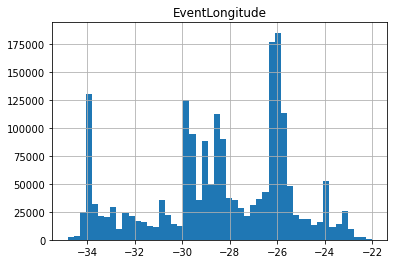

In [31]:
bakers_events_df.hist(column='EventLongitude', by=None, grid=True, xlabelsize=None, xrot=None, ylabelsize=None, yrot=None, ax=None, sharex=False, sharey=False, figsize=None, layout=None, bins=50, backend=None)

array([[<AxesSubplot:title={'center':'EventLatitude'}>]], dtype=object)

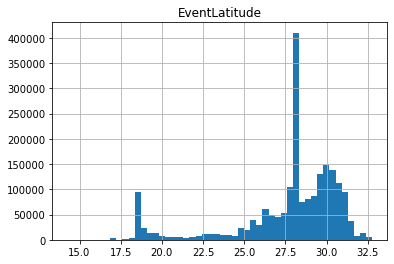

In [32]:
bakers_events_df.hist(column='EventLatitude', by=None, grid=True, xlabelsize=None, xrot=None, ylabelsize=None, yrot=None, ax=None, sharex=False, sharey=False, figsize=None, layout=None, bins=50, backend=None)

In [33]:
ruh_m = plt.imread('/media/lnr-ai/christo/github_repos/logistics/maps/map.png')

In [ ]:
bakers_events_df['Event Description']

In [38]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(bakers_events_df['Event Description'])

LabelEncoder()

In [41]:
bakers_events_df['event_encoded']=le.transform(bakers_events_df['Event Description'])

In [36]:
list(bakers_events_df)

['EventTypeId',
 'DriverId_u0',
 'Source',
 'GroupId',
 'AssetId_u0',
 'EventId',
 'EventDateTime',
 'OdometerKilometres_u0',
 'OdometerKilometresEnd_u0',
 'EventLongitude',
 'EventLatitude',
 'EventSpeed',
 'Value',
 'EventTotalTime',
 '__KEY_root',
 'Armed',
 'Priority',
 'Name',
 'EmployeeNumber',
 'Event Description',
 'EventDateTime_Conv',
 'EventDateTimeSeconds',
 'EventDate',
 'EventTime',
 'EventDateSeconds',
 'EventDaySeconds',
 'dayofweek']

No handles with labels found to put in legend.


.Harsh Braking > 8km/h/s (MV)(Trucks) 1936245   -28.234669
1936246   -33.966438
1936247   -28.565281
1936248   -33.726055
1936249   -33.879581
             ...    
1977345   -22.810440
1977346   -27.179270
1977347   -23.170309
1977348   -33.995472
1977349   -27.457666
Name: EventLongitude, Length: 41034, dtype: float64 1936245    28.307869
1936246    18.556360
1936247    29.779360
1936248    18.455584
1936249    18.522028
             ...    
1977345    30.551250
1977346    28.712566
1977347    30.049419
1977348    18.639139
1977349    32.024834
Name: EventLatitude, Length: 41034, dtype: float64
.Harsh Braking >10km/h/s (LDV/Fuso F) (MV) 2027794   -29.578279
2027795   -26.253441
2027796   -26.305059
2027797   -26.310579
2027798   -25.964081
             ...    
2045620   -25.182171
2045621   -26.179079
2045622   -26.254530
2045623   -25.137638
2045624   -26.347969
Name: EventLongitude, Length: 17830, dtype: float64 2027794    30.362080
2027795    28.098169
2027796    28.112190
2027797 

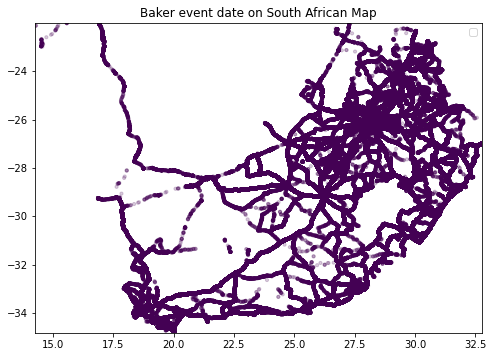

In [47]:
groups = bakers_events_df.groupby('Event Description')
fig, ax = plt.subplots(figsize = (8,7))
for name, group in groups:
    print(name,group.EventLongitude,group.EventLatitude)
    ax.scatter(group.EventLatitude,group.EventLongitude,  zorder=1, alpha= 0.2, c=group.event_encoded, s=10)
ax.set_title('Baker event date on South African Map')
ax.set_xlim(BBox[2],BBox[3])
ax.set_ylim(BBox[0],BBox[1])
ax.imshow(ruh_m, zorder=0, extent = BBox, aspect= 'equal')
plt.legend()

In [ ]:
    plt.plot(group.x, group.y, marker='o', linestyle='', markersize=12, label=name)

plt.legend()

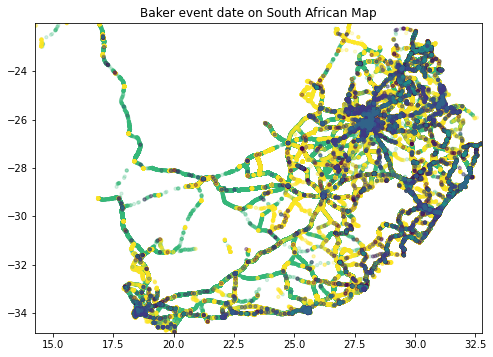

In [42]:
fig, ax = plt.subplots(figsize = (8,7))
ax.scatter(bakers_events_df.EventLatitude,bakers_events_df.EventLongitude,  zorder=1, alpha= 0.2, c=bakers_events_df['event_encoded'], s=10)
ax.set_title('Baker event date on South African Map')
ax.set_xlim(BBox[2],BBox[3])
ax.set_ylim(BBox[0],BBox[1])
ax.imshow(ruh_m, zorder=0, extent = BBox, aspect= 'equal')

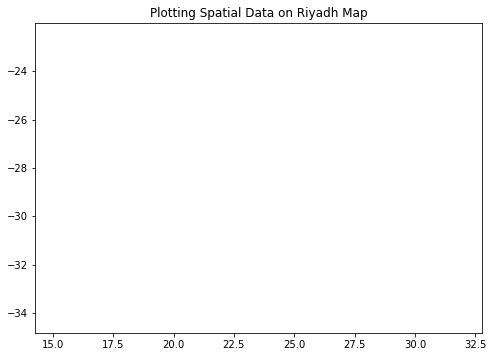

In [35]:
fig, ax = plt.subplots(figsize = (8,7))
ax.scatter(bakers_events_df.EventLongitude, bakers_events_df.EventLatitude, zorder=1, alpha= 0.2, c='b', s=10)
ax.set_title('Plotting Spatial Data on Riyadh Map')
ax.set_xlim(BBox[2],BBox[3])
ax.set_ylim(BBox[0],BBox[1])
ax.imshow(ruh_m, zorder=0, extent = BBox, aspect= 'equal')

### Aggregation and Pivotting:

1.The following Pivots the bakers_events_df dataframe on DriverId_u0 (so by driver) to reveal the total duration all instances of a particular type of event for a certain driver and assigns to driver_event_duration_df:

In [ ]:
driver_event_duration_df=pd.pivot_table(bakers_events_df, values='EventTotalTime', 
                    index=['EmployeeNumber'], 
                    columns='Event Description',
                    aggfunc='sum')

Rename columns with a duration prefix:

In [ ]:
driver_event_duration_list=list(driver_event_duration_df)
rename_dict={}
for column_name in driver_event_duration_list:
    rename_dict[column_name]=column_name+'_duration'
driver_event_duration_df.rename(columns=rename_dict,inplace=True)

In [ ]:
driver_event_duration_df.fillna(0,inplace=True)

2.Create the aggregation on count:

In [ ]:
driver_event_count_df=pd.pivot_table(bakers_events_df, values='EventTotalTime', 
                    index=['EmployeeNumber'], 
                    columns='Event Description',
                    aggfunc='count')

Rename columns with a \_count postfix:

In [ ]:
driver_event_count_list=list(driver_event_count_df)
rename_dict={}
for column_name in driver_event_count_list:
    rename_dict[column_name]=column_name+'_count'
driver_event_count_df.rename(columns=rename_dict,inplace=True)

In [ ]:
driver_event_count_df.fillna(0,inplace=True)

3.Create aggregation on the maximum duration:

In [ ]:
driver_event_maxduration_df=pd.pivot_table(bakers_events_df, values='EventTotalTime', 
                    index=['EmployeeNumber'], 
                    columns='Event Description',
                    aggfunc='max')

In [ ]:
driver_event_maxduration_list=list(driver_event_maxduration_df)
rename_dict={}
for column_name in driver_event_maxduration_list:
    rename_dict[column_name]=column_name+'_max'
driver_event_maxduration_df.rename(columns=rename_dict,inplace=True)

In [ ]:
driver_event_maxduration_df.fillna(0,inplace=True)

In [ ]:
driver_event_meanduration_df=pd.pivot_table(bakers_events_df, values='EventTotalTime', 
                    index=['EmployeeNumber'], 
                    columns='Event Description',
                    aggfunc='mean')

In [ ]:
driver_event_meanduration_list=list(driver_event_meanduration_df)
rename_dict={}
for column_name in driver_event_maxduration_list:
    rename_dict[column_name]=column_name+'_mean'
driver_event_meanduration_df.rename(columns=rename_dict,inplace=True)

In [ ]:
driver_event_meanduration_df.fillna(0,inplace=True)

Merge the duration,count,max and mean dataframes:

In [ ]:
driver_event_df=driver_event_count_df.merge(driver_event_duration_df,left_index=True,right_index=True)
driver_event_df=driver_event_df.merge(driver_event_maxduration_df,left_index=True,right_index=True)
driver_event_df=driver_event_df.merge(driver_event_meanduration_df,left_index=True,right_index=True)

In [ ]:
driver_event_df.head()

In [ ]:
event_employee_list=list(set(bakers_events_df[~bakers_events_df['EmployeeNumber'].isnull()]['EmployeeNumber']))

In [ ]:
driver_event_df.shape

In [ ]:
driver_event_df.reset_index(inplace=True)

### Load the accident log:

In [ ]:
filename='Copy of Accident Log.xlsx'
sheet_name='BT L'
# sheet_name='Fuel Consumption & Events Data'
accident_log_df=pd.read_excel('/media/lnr-ai/christo/github_repos/logistics/data/{filename}'.format(filename=filename), sheet_name=sheet_name)

In [ ]:
accident_log_df=accident_log_df[~accident_log_df['Mix Id Match'].isnull()].copy()
accident_log_df.shape

In [ ]:
list(accident_log_df)

In [ ]:
max(accident_log_df['Date Of Accident'])

In [ ]:
# Remove 'T' from the Event Date Time column:
accident_log_df['EventDateTime']=accident_log_df['EventDateTime'].str.replace('T', ' ', regex=False)
# Remove '.000' from the Event Date Time column:
bakers_events_df['EventDateTime']=bakers_events_df['EventDateTime'].str.replace('.000', '', regex=False)
bakers_events_df['EventDateTime_Conv']=bakers_events_df['EventDateTime'].apply(lambda x: (datetime.datetime.strptime(x, "%Y-%m-%d %H:%M:%S")))
bakers_events_df['EventDateTimeSeconds']=bakers_events_df['EventDateTime_Conv'].astype(int)
# Create date and time columns from EventDateTime:
bakers_events_df[['EventDate','EventTime']]=bakers_events_df['EventDateTime'].str.split(' ', expand=True)

In [ ]:
bakers_events_df['EventDate']=bakers_events_df['EventDate'].apply(lambda x: (datetime.datetime.strptime(x, "%Y-%m-%d")))

Create the EventDateSeconds column.  This is the number of seconds since the start of the day.  From here we can work out the time of day for any event.

In [ ]:
bakers_events_df['EventDateSeconds']=bakers_events_df['EventDate'].astype(int)
bakers_events_df['EventDateSeconds']=bakers_events_df['EventDateSeconds'].astype(int)

In [ ]:
bakers_events_df['EventDateSeconds']

In [ ]:
bakers_events_df['EventDaySeconds']=(bakers_events_df['EventDateTimeSeconds']-bakers_events_df['EventDateSeconds'])/10e8
bakers_events_df['EventDaySeconds']=bakers_events_df['EventDaySeconds'].astype(int)

In [ ]:
bakers_events_df['EventDaySeconds']

In [ ]:
bakers_events_df['dayofweek']=bakers_events_df['EventDateTime_Conv'].dt.dayofweek

In [ ]:
accident_log_list=list(accident_log_df)

In [ ]:
# accident_log_df.merge(bakers_events_df,left_on='Emp No',right_on='EmployeeNumber')

In [ ]:
bakers_events_df.dtypes

In [ ]:
accident_log_df.dtypes

In [ ]:
accident_log_df['Mix Id Match']=accident_log_df['Mix Id Match'].astype(int)

In [ ]:
accident_log_list=['Mix EmployeeNo',
 'MiX Employee Name',
 'Mix Id Match',
 'Claim No.',
 'Emp No',
 'ID Number',
 'Date Of Accident',
 'Date Reported',
 'Time',
 'Full Accident Details',
 'Severity Indication',
 'Horse Reg',
 'T1 Reg',
 'T2 Reg',
 'Asset No. Horse',
 'Asset No. T1',
 'Asset No. T2',
 'Loaded From',
 'Loaded With',
 'Destined To',
 'Customer KPI Infringement',
 'Vehicle Type',
 'Vehicle Category',
 'Vehicle Site',
 'Driver Name',
 'Driver Based At',
 'Age',
 'Date of Employment',
 'Years employed at Bakers',
 'Place',
 'Province',
 'City/Town',
 'Highway/Street Name',
 'Driver Injury',
 'Driver Fatality',
 'T/P Injury',
 'T/P Fatality',
 'Pedestrian Injury',
 'Pedestrian Fatality',
 'Potential Negligence',
 'Road Condition',
 'Root Cause Category',
 'Root Cause Analysis',
 'Description Catergory',
 'Avoidance (Added)',
 'Negligence (Added)',
 'RTMS Related (Added)',
 'Event',
 'Damage/s/d',
 'Est Cost of Accident (Incl Damage Control & 3rd Party Damages)',
 'EXCESS (Primary)',
 'SECTION II EXCESS',
 'SETTLEMENT',
 'TP SETTLED',
 'OUTSTANDING',
 'TP/OWN RECOVERY',
 'SALVAGE WORTH',
 'Minor Damages & Damage Control (Bakers Personal Capacity)',
 'SALVAGE EST SELLING PRICE']

In [ ]:
# fname='Bakers_Events.csv'
# Bakers_Events_df=pd.read_csv(filepath_or_buffer='/media/lnr-ai/christo/github_repos/logistics/data/{fname}'.format(fname=fname))

Create a list of unique employees in the accident dataframe:

In [ ]:
accident_employee_list=list(set(accident_log_df['Emp No']))

In [ ]:
len(accident_employee_list)

In [ ]:
len(intersection(lst1=event_employee_list, lst2=accident_employee_list))

In [ ]:
len(event_employee_list)

In [ ]:
1-64/926

Create a list of unique employees in the accident report and ALSO in the event dataframe:

In [ ]:
accident_event_employee_list=intersection(lst1=event_employee_list, lst2=accident_employee_list)

In [ ]:
driver_event_df['accident']=0

In [ ]:
driver_event_df.loc[driver_event_df['EmployeeNumber'].isin(accident_event_employee_list),'accident']=1

In [ ]:
driver_event_df.shape

In [ ]:
list(driver_event_df)

In [ ]:
driver_event_df.to_csv('/media/lnr-ai/christo/github_repos/logistics/data/driver_event_train_df.csv',index=False)

In [ ]:
accident_log_df[accident_log_df['Emp No']==accident_event_employee_list[1]]

In [ ]:
min(bakers_events_df[bakers_events_df.EmployeeNumber==accident_event_employee_list[1]]['EventDateTime'])

### -----------------------------------------------------------------------------------------------------------------

In [ ]:
Bakers_Events_df.EventLongitude

In [ ]:
set(Bakers_Events_df['Event Description'])

In [ ]:
list(Bakers_Events_df)

In [ ]:
pd.pivot_table(Bakers_Events_df, values='EventTotalTime', 
                    index=['DriverId_u0'], 
                    columns='Event Description',
                    aggfunc='sum')

In [ ]:
# Using readline() 
file_name='/media/lnr-ai/christo/github_repos/logistics/data/{fname}'.format(fname=fname)

In [ ]:
file1 = open(file_name, 'r') 
count = 0
  
while count<1000: 
    count += 1
  
    # Get next line from file 
    line = file1.readline() 
  
    # if line is empty 
    # end of file is reached 
    if not line: 
        break
    print("Line{}: {}".format(count, line.strip())) 
  
file1.close() 

In [ ]:
pd.read_html(io=file_name)

In [ ]:
print(file_name)

In [ ]:
import xml.etree.ElementTree as ET

In [ ]:
parse = ET.parse(file_name)

In [ ]:
from bs4 import BeautifulSoup

with open(file_name) as fp:
#     soup = BeautifulSoup(fp, 'xml')
    soup = BeautifulSoup(fp, 'lxml',from_encoding='Latin-1')

In [ ]:
fname='Site.csv (txt)'
fname='Organisation.csv (txt)'
file_name='/media/lnr-ai/christo/github_repos/logistics/data/{fname}'.format(fname=fname)

In [ ]:
from bs4 import BeautifulSoup

with open(file_name) as fp:
#     soup = BeautifulSoup(fp, 'xml')
    soup = BeautifulSoup(fp, 'xml')

In [ ]:
soup

In [ ]:
print(soup.prettify())

In [ ]:
pd.read_html(file_name)